# Explore ROOT files containing the simulated data

## Look at whats in a .digi.root file

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import ROOT

sys.path.append("..")
from helpers import filename_for

Welcome to JupyROOT 6.16/00


In [2]:
distance = 15
doubleplane = 30
energy = 600
erel = 500
neutron = 6
physics = "inclxx"
subrun = 0

In [3]:
filename = filename_for(distance, doubleplane, energy, erel, neutron, physics, subrun, "digi.root")
tfile = ROOT.TFile.Open(os.fspath(filename))
tfile.ls()

TFile**		/srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/data/15m_30dp_600AMeV_500keV_6n.inclxx.00.digi.root	
 TFile*		/srv/storage/gpfs/user/jmayer/Simulations/NeuLAND-reconstruction-ml/data/15m_30dp_600AMeV_500keV_6n.inclxx.00.digi.root	
  KEY: TFolder	cbmout;1	Main Folder
  KEY: TList	BranchList;1	Doubly linked list
  KEY: TList	TimeBasedBranchList;1	Doubly linked list
  KEY: FairFileHeader	FileHeader;1	
  KEY: TTree	evt;7	/cbmout
  KEY: TTree	evt;6	/cbmout
  KEY: TTree	evt;5	/cbmout
  KEY: TDirectoryFile	R3BNeulandDigitizer;1	R3BNeulandDigitizer
  KEY: TDirectoryFile	R3BNeulandPrimaryInteractionFinder;1	R3BNeulandPrimaryInteractionFinder
  KEY: TDirectoryFile	NeulandMCMon;1	NeulandMCMon
  KEY: TDirectoryFile	NeulandHitMon;1	NeulandHitMon
  KEY: TDirectoryFile	NeulandPrimaryClusterMon;1	NeulandPrimaryClusterMon
  KEY: TDirectoryFile	NeulandClusterMon;1	NeulandClusterMon


In [4]:
ttree = tfile.Get("evt")
[b.GetName() for b in ttree.GetListOfBranches()]

['EventHeader.',
 'NeulandHits',
 'NeulandClusters',
 'NeulandPrimaryTracks',
 'NeulandPrimaryPoints',
 'NeulandPrimaryHits',
 'NeulandPrimaryClusters',
 'NeulandSecondaryClusters']

In [5]:
i = 0
for event in ttree:
    print(
        neutron,
        event.NeulandPrimaryPoints.GetEntries(),
        event.NeulandPrimaryHits.GetEntries(),
        event.NeulandHits.GetEntries(),
        event.NeulandClusters.GetEntries(),
    )
    i += 1
    if i > 10:
        break

6 6 6 114 38
6 6 6 87 33
6 6 6 90 40
6 5 5 90 34
6 6 6 99 25
6 6 5 89 35
6 6 6 69 24
6 6 6 72 37
6 6 6 72 33
6 6 6 96 33
6 6 6 90 41


In [6]:
tfile.Close()

## Look at some properties of Primary Hits - the data we later want to reconstruct with ML

Using root_numpy for this example

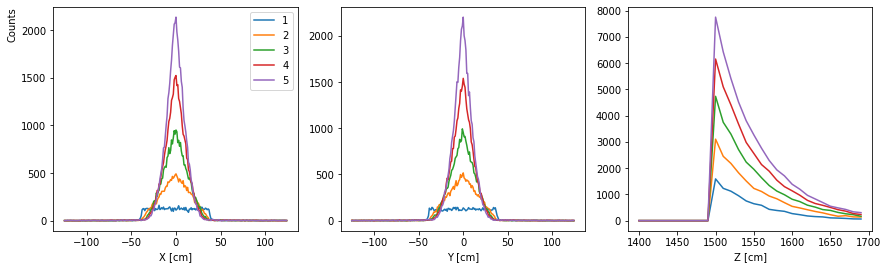

In [7]:
import root_numpy as rnp

fig = plt.figure(figsize=(2 * 6.224, 2 * (6.224 / 1.618 * 0.5)))

ax1 = fig.add_subplot(131)
ax1.set_ylabel(r"Counts", horizontalalignment="right", y=1)
ax1.set_xlabel(r"X [cm]")

ax2 = fig.add_subplot(132)
ax2.set_xlabel(r"Y [cm]")

ax3 = fig.add_subplot(133)
ax3.set_xlabel(r"Z [cm]")

for neutron in range(1, 6):
    filename = filename_for(distance, doubleplane, energy, erel, neutron, physics, subrun, "digi.root")
    tfile = ROOT.TFile.Open(os.fspath(filename))
    ttree = tfile.Get("evt")
    hx = ROOT.TH1F("hx", "Title", 250, -125, 125)
    hy = ROOT.TH1F("hy", "Title", 250, -125, 125)
    hz = ROOT.TH1F("hz", "Title", 30, 1400, 1700)
    ttree.Draw("NeulandPrimaryPoints.fX>>hx")
    ttree.Draw("NeulandPrimaryPoints.fY>>hy")
    ttree.Draw("NeulandPrimaryPoints.fZ>>hz")
    ax1.plot(range(-125, 125), rnp.hist2array(hx), label=str(neutron))
    ax2.plot(range(-125, 125), rnp.hist2array(hy))
    ax3.plot(range(1400, 1700, 10), rnp.hist2array(hz))

ax1.legend()
fig.tight_layout()

## Look at some properties of all Hits - data we can derive features from

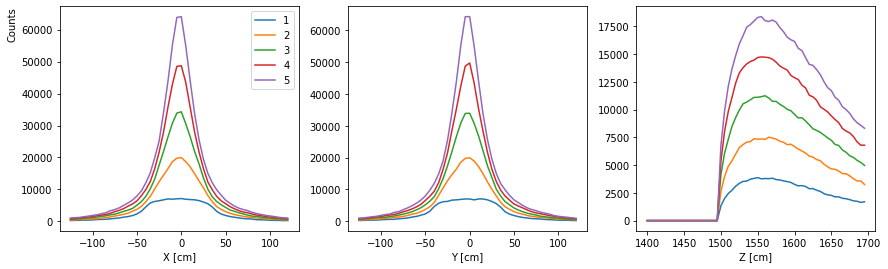

In [8]:
fig = plt.figure(figsize=(2 * 6.224, 2 * (6.224 / 1.618 * 0.5)))

ax1 = fig.add_subplot(131)
ax1.set_ylabel(r"Counts", horizontalalignment="right", y=1)
ax1.set_xlabel(r"X [cm]")

ax2 = fig.add_subplot(132)
ax2.set_xlabel(r"Y [cm]")

ax3 = fig.add_subplot(133)
ax3.set_xlabel(r"Z [cm]")

for neutron in range(1, 6):
    filename = filename_for(distance, doubleplane, energy, erel, neutron, physics, subrun, "digi.root")
    tfile = ROOT.TFile.Open(os.fspath(filename))
    ttree = tfile.Get("evt")
    hx = ROOT.TH1F("hx", "Title", 50, -125, 125)
    hy = ROOT.TH1F("hy", "Title", 50, -125, 125)
    hz = ROOT.TH1F("hz", "Title", 60, 1400, 1700)
    ttree.Draw("NeulandHits.fPosition.fX>>hx")
    ttree.Draw("NeulandHits.fPosition.fY>>hy")
    ttree.Draw("NeulandHits.fPosition.fZ>>hz")
    ax1.plot(range(-125, 125, 5), rnp.hist2array(hx), label=str(neutron))
    ax2.plot(range(-125, 125, 5), rnp.hist2array(hy))
    ax3.plot(range(1400, 1700, 5), rnp.hist2array(hz))

ax1.legend()
fig.tight_layout()

## Some properties of events, e.g. for multiplicity reconstruction

Unsing plain ROOT in Python here (slow)

In [9]:
def digidata(nmax):
    t = []
    for neutron in range(1, nmax + 1):
        filename = filename_for(distance, doubleplane, energy, erel, neutron, physics, subrun, "digi.root")
        tfile = ROOT.TFile.Open(os.fspath(filename))
        ttree = tfile.Get("evt")
        for event in ttree:
            # nPN: Number of incoming primary neutrons
            nIn = neutron
            # nPP: Number of primary neutrons with an energy deposition in NeuLAND
            nPP = event.NeulandPrimaryPoints.GetEntries()
            # nPH: Number of hits that correspond to a energy deposition of a primary neutron
            nPH = event.NeulandPrimaryHits.GetEntries()
            # nHits: Number of hits
            num_hits = event.NeulandHits.GetEntries()
            # nClus: Number of clusters
            num_clusters = event.NeulandClusters.GetEntries()
            # Edep: Total deposited (detected) energy
            # FIXME: why are there nans !?
            edep = round(sum([np.nan_to_num(hit.GetE()) for hit in event.NeulandHits]))

            t.append([nIn, nPP, nPH, num_hits, num_clusters, edep])

    df = pd.DataFrame(t)
    df.columns = ["nIn", "nPP", "nPH", "num_hits", "num_cluster", "edep"]
    return df

In [10]:
data = digidata(6)

In [11]:
pd.options.display.max_rows = 15
data.style.hide_index()
display(data)

,nIn,nPP,nPH,num_hits,num_cluster,edep
0,1,1,1,12,8,245.0
1,1,1,1,6,6,167.0
2,1,0,0,0,0,0.0
3,1,1,1,13,1,322.0
4,1,1,1,15,5,206.0
...,...,...,...,...,...,...
59995,6,6,6,89,29,1852.0
59996,6,5,5,43,18,783.0
59997,6,6,6,130,41,1644.0
59998,6,6,6,106,33,1971.0


In [12]:
nmax = 6
hits = [
    np.histogram(data[data["nPH"] == n]["num_hits"], range=(0, 150), bins=150, density=True)[0]
    for n in range(1, nmax + 1)
]
clus = [
    np.histogram(data[data["nPH"] == n]["num_cluster"], range=(0, 75), bins=75, density=True)[0]
    for n in range(1, nmax + 1)
]
edep = [
    np.histogram(data[data["nPH"] == n]["edep"], range=(0, 3000), bins=150, density=True)[0] for n in range(1, nmax + 1)
]

Using matplotlib backend: agg


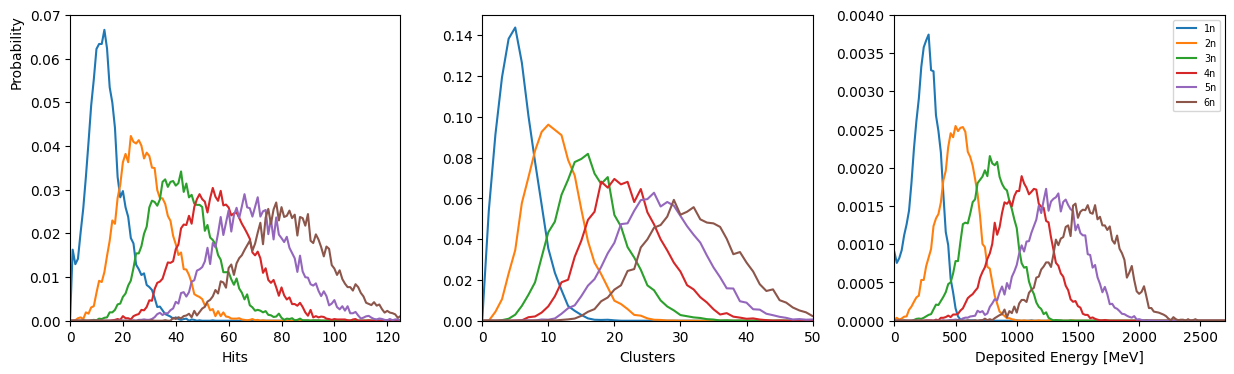

In [13]:
%matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(2 * 6.224, 6.224 / 1.618))

ax1 = fig.add_subplot(131)
ax1.set_xlim(0, 125)
ax1.set_ylim(0, 0.07)
for h in hits:
    ax1.plot(h)
ax1.set_ylabel(r"Probability", horizontalalignment="right", y=1)
ax1.set_xlabel(r"Hits")

ax2 = fig.add_subplot(132)
ax2.set_xlim(0, 50)
ax2.set_ylim(0, 0.15)
for c in clus:
    ax2.plot(c)
ax2.set_xlabel(r"Clusters")

xs = np.arange(0, 3000, 3000 / 150)
ax3 = fig.add_subplot(133)
ax3.set_xlim(0, 2700)
ax3.set_ylim(0, 0.004)
for i, e in enumerate(edep, 1):
    ax3.plot(xs, e, label=f"{i}n")
ax3.set_xlabel(r"Deposited Energy [MeV]")

ax3.legend(prop={"size": "x-small"})

fig.tight_layout()
display(fig)